In [2]:
dut.reset_chip()
dut.reset_dpe()
dut.ground_PIC()
dut.power_on()

DAC initialized to a span from 0 V to 5 V


In [23]:
dut.disconnect()

Serial port disconnected.


In [1]:
%reload_ext autoreload
%autoreload 2

import dut_func as dut
import serial
import time
import struct
import numpy as np
# from bitarray import bitarray
from bitstring import BitArray
import matplotlib.pyplot as plt
# %config InlineBackend.figure_formats = ['svg']
import dut_a0 as a0

from misc import *

# dut.drv.serUSB = 'COM19'
drv = dut.drv

ser = serial.Serial('COM3', 9600, timeout=1)
dut.connect(ser)

Test with a IV sweep

5.00-

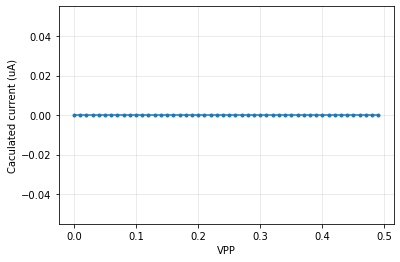

In [3]:
ar=2
r=31
c=0

Vreads = np.arange(0, 0.5, 0.01)
# Vgates = np.arange(0,5,0.5)
# Vgates = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 5]
Vgates = [5]

volts_set = []

for Vgate in Vgates:
    print(f'{Vgate:.2f}', end='-')
    volts = []
    for vread in Vreads:
        volts.append( a0.read_single_int(vread, Vgate, array=ar, row=r, col=c, gain=1) )
    volts_set.append(volts)
    
for volts in volts_set:
    plt.plot(Vreads, [i* 1e6 for i in volts], '.-')
    
plt.xlabel('VPP')
plt.ylabel('Caculated current (uA)')
plt.grid(True, alpha=0.3)
# plt.ylim(-0.1, 6)

In [108]:
drv.clk_stop('ADC_CK')
drv.clk_stop('CK_ARRAY')
drv.clk_config('ADC_CK', divisor=2)
drv.clk_config('CK_ARRAY', divisor=2)
drv.clk_start('ADC_CK')
drv.clk_start('CK_ARRAY')

Setting ADC_CK freq=50000.0kHz
Setting CK_ARRAY freq=50000.0kHz


Batch read domo

Reading array0
Reading array1
Reading array2
0.7528882026672363


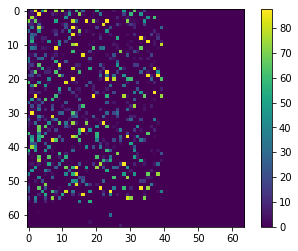

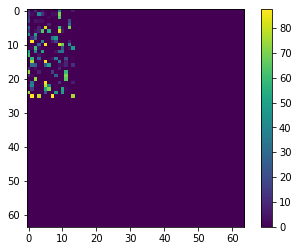

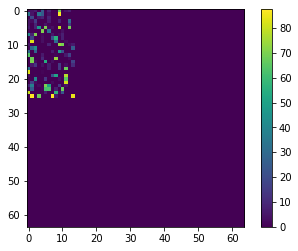

In [102]:
ts = time.time()
Vr = 0.2
Gmaps = []

for arr in range(3):
    print('Reading array' + str(arr))
    Gmaps.append( a0.pic_read_batch(arr, Vread=Vr, gain=-1) / Vr )
print(time.time()-ts)

for i in range(3):
    plt.figure(i)
    plt.imshow(Gmaps[i] * 1e6)
    plt.colorbar()

Reading array0
Reading array1
Reading array2
2.581066131591797


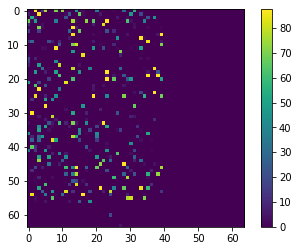

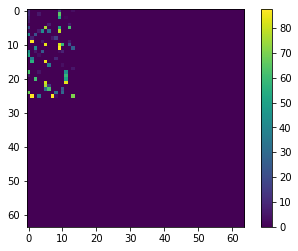

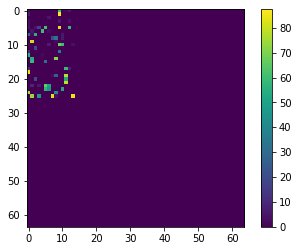

In [107]:
ts = time.time()
Vr = 0.2
Gmaps = []

for arr in range(3):
    print('Reading array' + str(arr))
    Gmaps.append( a0.pic_read_batch(arr, Vread=Vr, gain=-1) / Vr )
print(time.time()-ts)

for i in range(3):
    plt.figure(i)
    plt.imshow(Gmaps[i] * 1e6)
    plt.colorbar()

DPE read with unselected rows grounded

0.08052825927734375


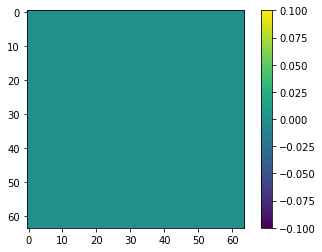

In [8]:
input = [0x1<<i for i in range(64)]
ts = time.time()
data = a0.pic_dpe_batch(0, input, gain=-1, Vread=0.2, mode=0) / 0.2
print(time.time()-ts)

plt.imshow(data * 1e6)
plt.colorbar()

In [112]:
dut.disconnect()

DPE read with unselected rows floated

0.08813619613647461


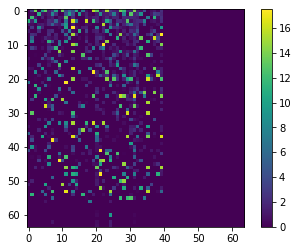

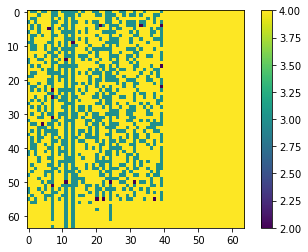

In [32]:
input = [0x1<<i for i in range(64)]

ts = time.time()
data = a0.pic_dpe_batch(0, input, gain=-1, Vread=0.2, mode=1, raw=True)
print(time.time()-ts)

plt.figure(1)
plt.imshow( a0.adc2current_array(data, 0.5) * 1e6 )
plt.colorbar()

plt.figure(2)
plt.imshow(data>>10)
plt.colorbar()

In [ ]:
# dd = np.array(data[1,:], dtype=np.uint16)
dd = data[1,:]
for d in dd:
    print( f'{d:013b}' )

################# WOWRKING WORKAROUDN #####################

--------------- It turns out we have to wait for 5ms -----------------

In [ ]:
ts = time.time()
Gmap = np.zeros((64, 64))
arr = 0
gn = -1
Vr = 0.2

a0.pic_read_config(gain=gn, Vread=Vr)

for r in range(64):
    for c in range(64):
        value = a0.pic_read_single(arr, r, c, skip_conf=True, gain=gn)
        Gmap[r,c] = value / Vr
        time.sleep(0.005)
        
print(time.time()-ts)

plt.imshow(Gmap)
plt.colorbar()

0.39938783645629883


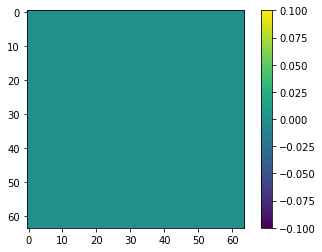

In [111]:
input = [0x1<<i for i in range(64)]

gn=3
Vr=0.2

ts = time.time()

data = np.zeros((64,64))
a0.pic_read_config(gain=gn, Vread=Vr)

for i in range(64):
    data[i] = a0.pic_dpe_batch(0, [input[i]], skip_conf=True, mode=1, gain=-1) 
    time.sleep(0.005)
    
print(time.time()-ts)

plt.imshow(data * 1e6)
plt.colorbar()

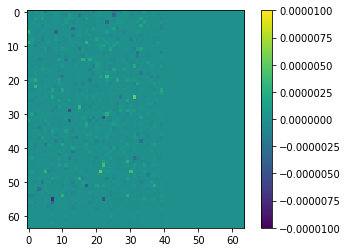

In [99]:
plt.imshow(data_store - data)
plt.clim(-0.00001, 0.00001)
plt.colorbar()

In [34]:
data_store = data

In [ ]:
# Python DPE

Vread = 0.2
Vgate =5
Gmap = np.zeros((64, 64))
for a in range(4):
    for b in range(16):
        row_vector = [0, 0, 0, 0]
        row_vector[3-a] = 0b1 << b
        Gmap[16*a+b] = a0.read_dpe_int(Vread, Vgate, row_vector, array=0, gain=2, Vref=0.5)
        
plt.imshow(Gmap)
plt.colorbar()

Test pic DAC set

In [9]:
drv.ser.write(b'302,' + str(0x9fff).encode() +b',\0')

11

In [29]:
dut.dac_set('P_ADC_EXT_TEST_IN', 0)

00397fff
ff7f3900


In [6]:
dut.dac_init()

DAC initialized to a span from 0 V to 5 V


DPE: 0-60, len=60
DPE: 60-64, len=4
0.04604029655456543


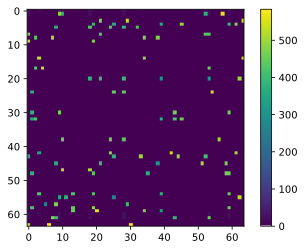

In [15]:
input = [0x1<<i for i in range(64)I]
ts = time.time()
data = a0.pic_dpe_batch(1, input, gain=2, Vread=0.2, mode=1) / 0.2
print(time.time()-ts)

plt.imshow(data * 1e6)
plt.colorbar()

Working on array 1 , device (row= 0 col= 0 )
Initial G= 0.0 Target G = 4e-06
Using Gain= 4 Vread= 0.2 Vread2= 0.15000000000000002


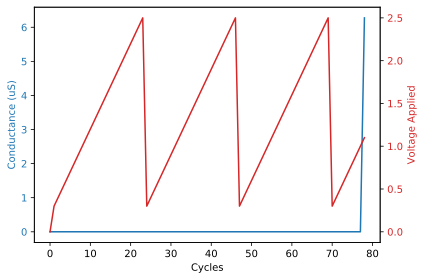

Working on array 1 , device (row= 1 col= 0 )
Initial G= 0.0 Target G = 1.4666666666666666e-05
Using Gain= 4 Vread= 0.1 Vread2= 0.07500000000000001


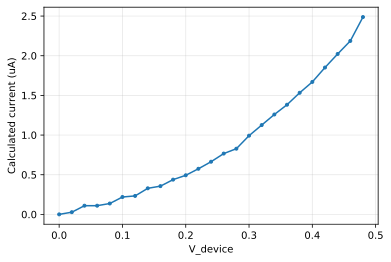

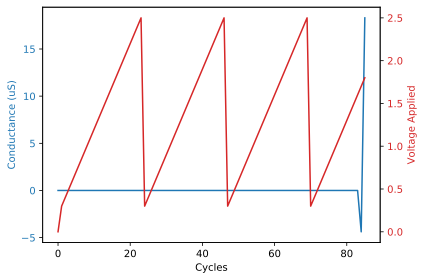

Working on array 1 , device (row= 2 col= 0 )
Initial G= 0.0 Target G = 2.5333333333333334e-05
Using Gain= 4 Vread= 0.05 Vread2= 0.037500000000000006


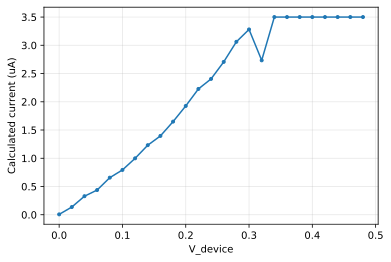

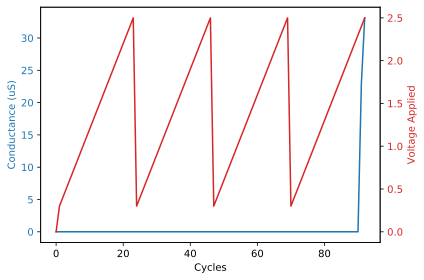

Working on array 1 , device (row= 3 col= 0 )
Initial G= 0.0 Target G = 3.600000000000001e-05
Using Gain= 4 Vread= 0.03 Vread2= 0.0225


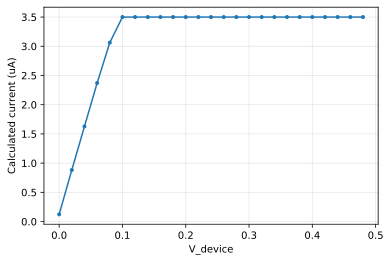

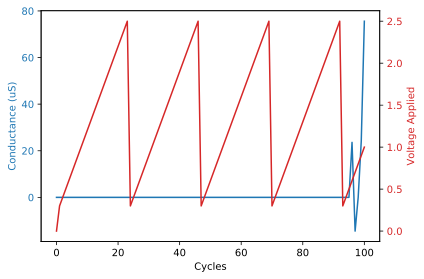

Working on array 1 , device (row= 4 col= 0 )
Initial G= 0.0 Target G = 4.666666666666667e-05
Using Gain= 4 Vread= 0.03 Vread2= 0.0225


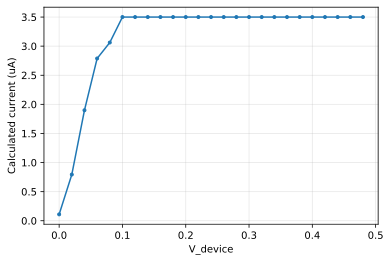

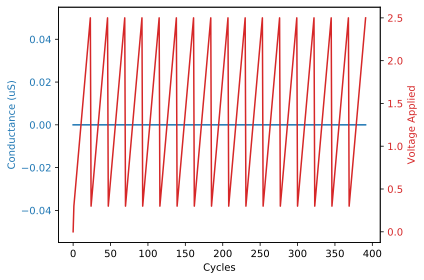

Working on array 1 , device (row= 5 col= 0 )
Initial G= 0.0 Target G = 5.7333333333333336e-05
Using Gain= 4 Vread= 0.03 Vread2= 0.0225


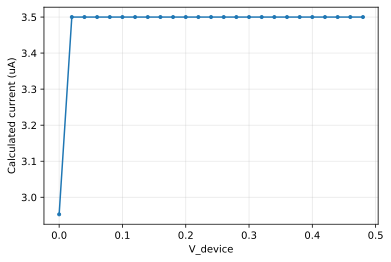

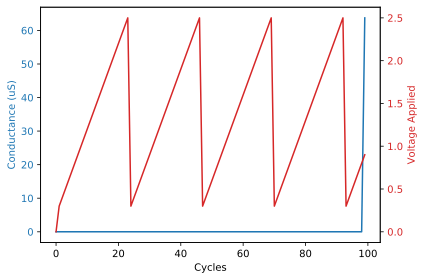

Working on array 1 , device (row= 6 col= 0 )
Initial G= 0.0 Target G = 6.800000000000001e-05
Using Gain= 3 Vread= 0.1 Vread2= 0.07500000000000001


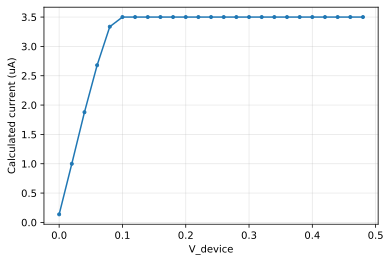

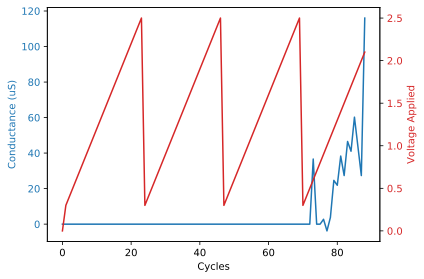

Working on array 1 , device (row= 7 col= 0 )
Initial G= 0.0 Target G = 7.866666666666668e-05
Using Gain= 3 Vread= 0.1 Vread2= 0.07500000000000001


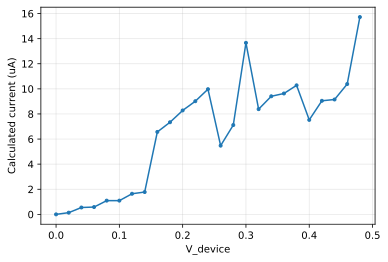

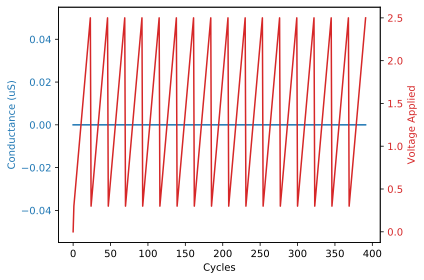

Working on array 1 , device (row= 8 col= 0 )
Initial G= 0.0 Target G = 8.933333333333334e-05
Using Gain= 3 Vread= 0.1 Vread2= 0.07500000000000001


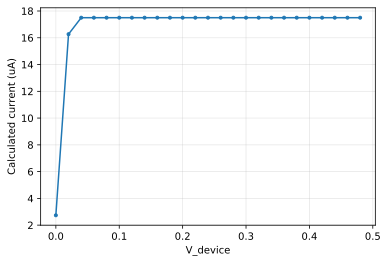

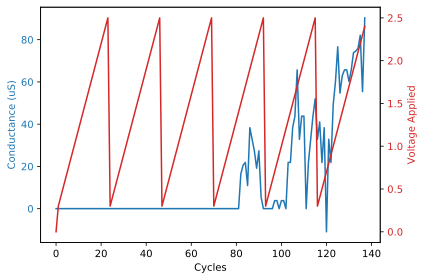

Working on array 1 , device (row= 9 col= 0 )
Initial G= 0.0 Target G = 0.0001
Using Gain= 3 Vread= 0.1 Vread2= 0.07500000000000001


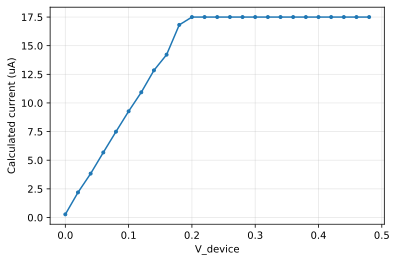

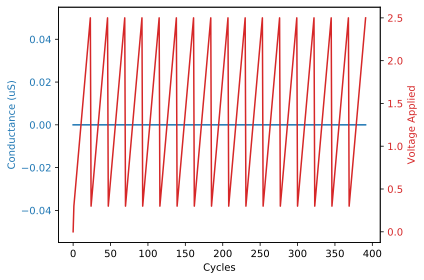

GHistory= [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.275659824046924e-06], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -4.3792766373411565e-06, 1.8299120234604112e-05], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

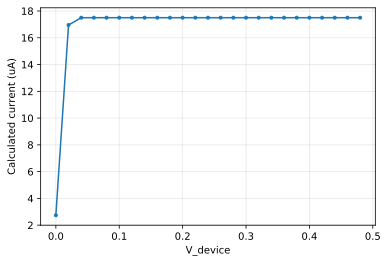

In [17]:
gainRes = np.array([1e3, 5e3, 3e4, 2e5, 1e6])
maxGainCurr = 3.5*0.85/gainRes
VreadGate = 5.0

maxGRange = np.array([1e-6, 8e-6, 16e-6, 32e-6, 64e-6, 100e-6, 165e-6, 300e-6, 500e-6])
gainChoice = np.array([4, 4, 4, 4, 4, 3, 3, 3])
minCurrentExp = np.array([1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6])
readV = np.array([0.4, 0.2, 0.1, 0.05, 0.03, 0.1, 0.05, 0.03])
readV2 = 0.75*readV

arr = 1
startRow = 0
startCol = 0
numRows = 10
numCols = 1
GMin = 4e-6
GMax = 100e-6

targetGVals = np.linspace(GMin, GMax, numRows)
targetRows = np.arange(startRow, startRow+numRows)
targetCols = np.arange(startCol, startCol+numCols)

#gainForTargetG = 4-np.searchsorted(np.flip(maxGainCurr),targetGVals)
targetGIndexSetting = np.searchsorted(maxGRange,targetGVals)

vAppliedSet = np.arange(0.3, 2.6, 0.1)
vAppliedReset = np.arange(0.3, 2.6, 0.1)
vGateSet = np.arange(0.5, 2.2, 0.1)
vGateReset = np.arange(5.0, 5.5, 0.5)
GHistory = []
VHistory = []
for j in range(numCols):
    cc = targetCols[j]
    for i in range(numRows):
        rr = targetRows[i]
        print('Working on array', arr, ', device (row=', rr, 'col=', cc, ')')
        thisGtarget = targetGVals[i]
        #thisGain = gainForTargetG[i]
        thisGain = gainChoice[targetGIndexSetting[i]]
        thisReadV = readV[targetGIndexSetting[i]]
        thisReadV2 = readV2[targetGIndexSetting[i]]
        minCurrExp = minCurrentExp[targetGIndexSetting[i]]
        thisGHistory = []
        thisVHistory = []
        thisGainHistory = []
        # Do a first read of this device
        currI1 = max(a0.read_single(thisReadV, VreadGate, array=arr, row=rr, col=cc, gain=thisGain), minCurrExp)
        currI2 = max(a0.read_single(thisReadV2, VreadGate, array=arr, row=rr, col=cc, gain=thisGain), minCurrExp)
        currG = (currI1-currI2)/(thisReadV-thisReadV2)
        thisGHistory.append(currG)
        thisVHistory.append(0)
        print('Initial G=', currG, 'Target G =', thisGtarget)
        print('Using Gain=', thisGain, 'Vread=', thisReadV, 'Vread2=', thisReadV2)        
        # Now, if device is lower than target, SET it
        if currG < thisGtarget:
            for vgate in vGateSet:
                for vappset in vAppliedSet:
                    # Apply vappset pulse, then read
                    a0.set_single_int(vappset, vgate, array=arr, row=rr, col=cc)
                    currI1 = max(a0.read_single(thisReadV, VreadGate, array=arr, row=rr, col=cc, gain=thisGain), minCurrExp)
                    currI2 = max(a0.read_single(thisReadV2, VreadGate, array=arr, row=rr, col=cc, gain=thisGain), minCurrExp)
                    #currI1 = a0.read_single_int(thisReadV, VreadGate, array=arr, row=rr, col=cc, gain=thisGain)
                    #currI2 = a0.read_single_int(thisReadV2, VreadGate, array=arr, row=rr, col=cc, gain=thisGain)
                    currG = (currI1-currI2)/(thisReadV-thisReadV2)
                    thisGHistory.append(currG)
                    thisVHistory.append(vappset)
                    if currG >= thisGtarget:
                        break
                if currG >= thisGtarget:
                    break
            GHistory.append(thisGHistory)
            VHistory.append(thisVHistory)

        # Else, if device is higher than target, RESET it
        elif currG > thisGtarget:
            for vgate in vGateReset:
                for vappreset in vAppliedReset:
                    # Apply vappreset pulse, then read
                    a0.reset_single_int(vappreset, vgate, array=arr, row=rr, col=cc)
                    currI1 = max(a0.read_single(thisReadV, VreadGate, array=arr, row=rr, col=cc, gain=thisGain), minCurrExp)
                    currI2 = max(a0.read_single(thisReadV2, VreadGate, array=arr, row=rr, col=cc, gain=thisGain), minCurrExp)
                    #currI1 = a0.read_single_int(thisReadV, VreadGate, array=arr, row=rr, col=cc, gain=thisGain)
                    #currI2 = a0.read_single_int(thisReadV2, VreadGate, array=arr, row=rr, col=cc, gain=thisGain)
                    currG = (currI1-currI2)/(thisReadV-thisReadV2)                    
                    thisGHistory.append(currG)
                    thisVHistory.append(-1*vappreset)
                    if currG <= thisGtarget:
                        break
                if currG <= thisGtarget:
                    break
            GHistory.append(thisGHistory)
            VHistory.append(thisVHistory)

        fig, ax1 = plt.subplots()
        color = 'tab:blue'
        ax1.set_xlabel('Cycles')
        ax1.set_ylabel('Conductance (uS)', color=color)
        ax1.plot([i* 1e6 for i in thisGHistory], color=color)
        ax1.tick_params(axis='y', labelcolor=color)
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        color = 'tab:red'
        # we already handled the x-label with ax1
        ax2.set_ylabel('Voltage Applied', color=color)
        ax2.plot(thisVHistory, color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.show()
        
        Vreads = np.arange(0, 0.5, 0.02)
        Vggate = 5
        volts = []
        for vread in Vreads:
            volts.append( a0.read_single(vread, Vggate, array=arr, row=rr, col=cc, gain=thisGain) )                
        plt.plot(Vreads, [i* 1e6 for i in volts], '.-')

        plt.xlabel('V_device')
        plt.ylabel('Calculated current (uA)')
        plt.grid(True, alpha=0.3)

    print('GHistory=', GHistory)
    print('VHistory=', VHistory)

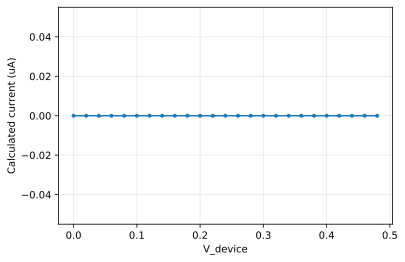

In [27]:
arr = 0
rr = 4
cc = 20
thisGain = 2
Vreads = np.arange(0, 0.5, 0.02)
Vggate = 5
volts = []
for vread in Vreads:
    volts.append( a0.read_single(vread, Vggate, array=arr, row=rr, col=cc, gain=thisGain) )                
plt.plot(Vreads, [i* 1e6 for i in volts], '.-')

plt.xlabel('V_device')
plt.ylabel('Calculated current (uA)')
plt.grid(True, alpha=0.3)

Reading array0
Reading array1
Reading array2
2.1560299396514893


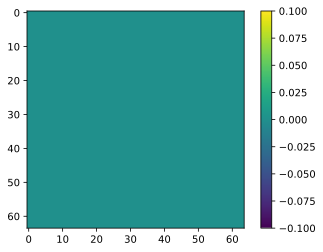

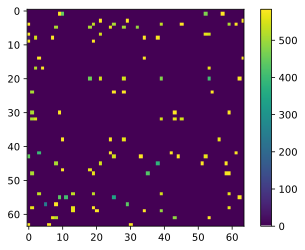

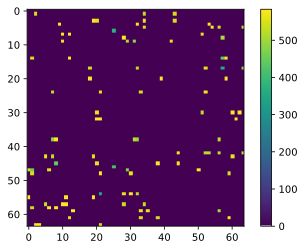

In [20]:
ts = time.time()
Vr = 0.2
Gmaps = []

for arr in range(3):
    print('Reading array' + str(arr))
    Gmaps.append( a0.pic_read_batch(arr, Vread=Vr, gain=2) / Vr )
print(time.time()-ts)

for i in range(3):
    plt.figure(i)
    plt.imshow(Gmaps[i] * 1e6)
    plt.colorbar()

Reading array0
Reading array1
Reading array2
2.16401743888855


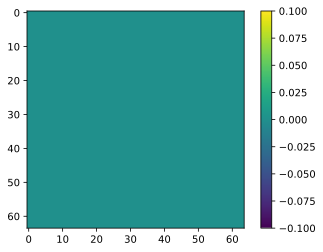

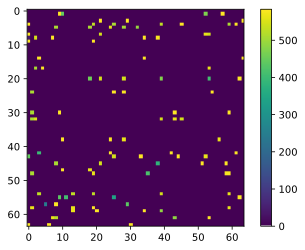

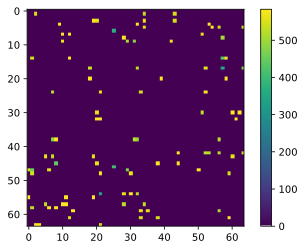

In [28]:
ts = time.time()
Vr = 0.2
Gmaps = []

for arr in range(3):
    print('Reading array' + str(arr))
    Gmaps.append( a0.pic_read_batch(arr, Vread=Vr, gain=2) / Vr )
print(time.time()-ts)

for i in range(3):
    plt.figure(i)
    plt.imshow(Gmaps[i] * 1e6)
    plt.colorbar()

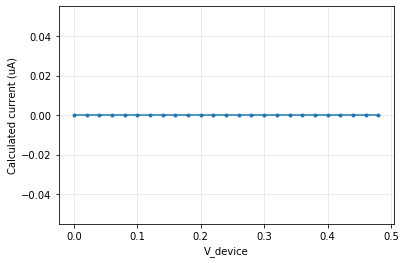

In [5]:
arr = 2
rr = 4
cc = 20
thisGain = 4
Vreads = np.arange(0, 0.5, 0.02)
Vggate = 5
volts = []
for vread in Vreads:
    volts.append( a0.read_single(vread, Vggate, array=arr, row=rr, col=cc, gain=thisGain) )                
plt.plot(Vreads, [i* 1e6 for i in volts], '.-')

plt.xlabel('V_device')
plt.ylabel('Calculated current (uA)')
plt.grid(True, alpha=0.3)

In [7]:
import random
arr = 0
Vread = 0.2
gains = np.array([4, 3, 2, 1, 0])
maxCurr = np.array([3.2e-3, 650e-6, 110e-6, 14.0e-6, 3.3e-6])
data = hex(random.getrandbits(16))
print(data)
DPECurr = []
for gg in gains:
    DPECurr.append(a0.pic_dpe_batch(arr, data, gain=gg, Vread=Vread, mode=1))
print(DPECurr)  

0x684c


error: required argument is not an integer

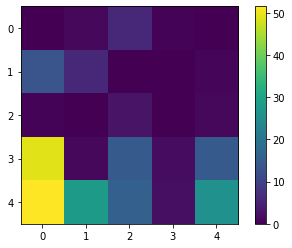

In [6]:
arr = 0
numRows = 5
numCols = 5
vRead = 0.2
vReadGate = 5.0
gains = np.array([4, 3, 2, 1, 0])
maxCurr = np.array([3.2e-3, 650e-6, 110e-6, 14.0e-6, 3.3e-6])
Gmeas = np.zeros((numRows, numCols))
for rr in range(numRows):
        for cc in range(numCols):
            for gg in gains:
                    rdCurr = a0.read_single(vRead, vReadGate, array=arr, row=rr, col=cc, gain=gg)
                    #print('Device Row =', rr, 'Col =', cc, 'Gain=', gg, ', I=', rdCurr)
                    if rdCurr < maxCurr[gg]:
                        break
            Gmeas[rr,cc] = 1e6*rdCurr/vRead
            #print(Gmeas[rr,cc]*1e6)

plt.imshow(Gmeas)
plt.colorbar()

In [8]:
curr = a0.pic_dpe_batch(0, 0xaaaa, gain=4, Vread=0.2, mode=1)

TypeError: object of type 'int' has no len()

0.37204575538635254


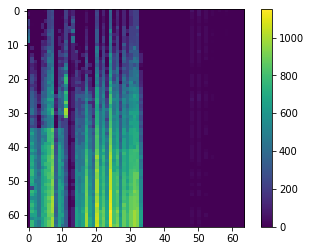

In [9]:
input = [0x1<<i for i in range(64)]

gn=2
Vr=0.2

ts = time.time()

data = np.zeros((64,64))
a0.pic_read_config(gain=gn, Vread=Vr)

for i in range(64):
    data[i] = a0.pic_dpe_batch(0, [input[i]], skip_conf=True, mode=1) 
    time.sleep(0.005)
    
print(time.time()-ts)

plt.imshow(data * 1e6)
plt.colorbar()

In [23]:
a0.pic_dpe_batch(0, [int(random.getrandbits(16))], skip_conf=True, mode=1) 

array([[1.51221896e-03, 9.30596285e-04, 8.21114370e-04, 6.56891496e-04,
        1.34115347e-03, 9.03225806e-04, 1.32746823e-03, 1.01270772e-03,
        5.74780059e-04, 9.30596285e-04, 6.84261975e-04, 6.02150538e-04,
        2.46334311e-04, 1.04692082e-03, 9.30596285e-04, 9.85337243e-04,
        7.66373412e-04, 1.09481916e-03, 7.11632454e-04, 5.47409580e-04,
        1.58748778e-03, 7.66373412e-04, 1.20430108e-03, 8.75855327e-04,
        1.34457478e-03, 9.85337243e-04, 1.10850440e-03, 8.75855327e-04,
        1.23167155e-03, 9.85337243e-04, 1.01270772e-03, 1.23167155e-03,
        1.23167155e-03, 9.03225806e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        5.47409580e-05, 0.00000000e+00, 5.47409580e-05, 0.00000000e+00,
        2.73704790e-05, 0.00000000e+00, 0.00000000e+00, 0.000000

In [22]:
int(random.getrandbits(16))

20484

In [46]:
numInputs = 1
arr = 0
Vread = 0.2
gains = np.array([4, 3, 2, 1, 0])
maxCurr = np.array([3.2e-3, 650e-6, 110e-6, 14.0e-6, 3.3e-6])
inputPattern = np.zeros((numInputs,1))
DPECurr = np.zeros((5,64))
for ii in range(numInputs):
    newInputPattern = int(random.getrandbits(16))
    inputPattern[ii] = newInputPattern
    for gg in gains:
        DPECurr[gg] = a0.pic_dpe_batch(arr, [newInputPattern], gain=gg, Vread=Vread, mode=1)
        time.sleep(0.005)
        print('Gain=', gg,'DPE=', DPECurr[gg])

Gain= 4 DPE= [3.50000000e-06 3.50000000e-06 3.50000000e-06 3.50000000e-06
 3.50000000e-06 3.50000000e-06 3.50000000e-06 3.50000000e-06
 3.50000000e-06 3.50000000e-06 3.50000000e-06 3.50000000e-06
 3.50000000e-06 3.50000000e-06 3.50000000e-06 3.50000000e-06
 3.50000000e-06 3.50000000e-06 3.50000000e-06 3.50000000e-06
 3.50000000e-06 3.50000000e-06 3.50000000e-06 3.50000000e-06
 3.50000000e-06 3.50000000e-06 3.50000000e-06 3.50000000e-06
 3.50000000e-06 3.50000000e-06 3.50000000e-06 3.50000000e-06
 3.50000000e-06 3.50000000e-06 2.73704790e-08 0.00000000e+00
 2.73704790e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.84261975e-09 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.64222874e-07 1.36852395e-07 1.09481916e-07 1.09481916e-07
 1.09481916e-07 1.09481916e-07 1.09481916e-07 2.73704790e-08
 5.47409580e-08 5.47409580e-08 1.09481916e-07 1.36852395e-08
 5.47409580e-08 0.00000000e+00 5.47409580e-08 0.00000000e+00]
Gain= 3 DP

In [51]:
DPECurr[3]

array([1.75000000e-05, 1.75000000e-05, 1.75000000e-05, 1.75000000e-05,
       1.75000000e-05, 1.75000000e-05, 1.75000000e-05, 1.75000000e-05,
       1.75000000e-05, 1.75000000e-05, 1.75000000e-05, 1.75000000e-05,
       1.17521994e-05, 1.75000000e-05, 1.75000000e-05, 1.75000000e-05,
       1.75000000e-05, 1.75000000e-05, 1.75000000e-05, 1.75000000e-05,
       1.75000000e-05, 1.75000000e-05, 1.75000000e-05, 1.75000000e-05,
       1.75000000e-05, 1.75000000e-05, 1.75000000e-05, 1.75000000e-05,
       1.75000000e-05, 1.75000000e-05, 1.75000000e-05, 1.75000000e-05,
       1.75000000e-05, 1.75000000e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.73704790e-07, 0.00000000e+00, 2.73704790e-07, 0.00000000e+00,
       2.73704790e-07, 0.00000000e+00, 1.36852395e-07, 0.00000000e+00,
      

In [53]:
DPECurr[3] * (DPECurr[3]<=maxCurr[3])

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.17521994e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.73704790e-07, 0.00000000e+00, 2.73704790e-07, 0.00000000e+00,
       2.73704790e-07, 0.00000000e+00, 1.36852395e-07, 0.00000000e+00,
      

In [55]:
DPECurr[4] * (DPECurr[4]<=maxCurr[4])

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.73704790e-08, 0.00000000e+00,
       2.73704790e-08, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.84261975e-09, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.64222874e-07, 1.36852395e-07, 1.09481916e-07, 1.09481916e-07,
       1.09481916e-07, 1.09481916e-07, 1.09481916e-07, 2.73704790e-08,
      

In [64]:
mask = np.ones((1,64))
mask * (DPECurr[2] * (DPECurr[2]<=maxCurr[2]))
(DPECurr[2] * (DPECurr[2]<=maxCurr[2]))

array([4.74421636e-05, 3.74063213e-05, 3.14760508e-05, 2.55457804e-05,
       4.61876833e-05, 3.87748452e-05, 4.92668622e-05, 4.01433692e-05,
       2.73704790e-05, 4.01433692e-05, 3.10198762e-05, 2.55457804e-05,
       1.27728902e-05, 4.37927664e-05, 3.78624959e-05, 3.64939720e-05,
       3.37569241e-05, 4.28804171e-05, 3.10198762e-05, 2.55457804e-05,
       5.98729228e-05, 2.73704790e-05, 4.74421636e-05, 3.74063213e-05,
       5.99869664e-05, 4.01433692e-05, 4.28804171e-05, 3.37569241e-05,
       4.98370805e-05, 4.10557185e-05, 3.83186706e-05, 4.47051157e-05,
       4.43629847e-05, 4.01433692e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.82469860e-06, 0.00000000e+00, 1.82469860e-06, 0.00000000e+00,
       9.12349299e-07, 0.00000000e+00, 2.28087325e-07, 0.00000000e+00,
      

In [61]:
 1-(DPECurr[4]<=maxCurr[4])

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [62]:
(DPECurr[4]<=maxCurr[4])

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [80]:
ts = time.time()
numInputs = 5
arr = 0
Vread = 0.1
gains = np.array([4, 3, 2, 1, 0])
maxCurr = np.array([3.2e-3, 650e-6, 110e-6, 14.0e-6, 3.3e-6])
inputPattern = np.zeros((numInputs,1))
DPECurr = np.zeros((5,64))
finalDPECurrs = np.zeros((numInputs,64))
for ii in range(numInputs):
    newInputPattern = int(random.getrandbits(16))
    inputPattern[ii] = newInputPattern
    for gg in gains:
        DPECurr[gg] = a0.pic_dpe_batch(arr, [newInputPattern], gain=gg, Vread=Vread, mode=1)
        time.sleep(0.005)
        #print('Gain=', gg,'DPE=', DPECurr[gg])
    mask = np.ones((1,64))
    thisDPECurr = np.zeros((1,64))
    for gg in gains:
        thisDPECurr = thisDPECurr + (mask * (DPECurr[gg] * (DPECurr[gg]<=maxCurr[gg])))
        mask = mask * (1 - (DPECurr[gg]<=maxCurr[gg]))
    finalDPECurrs[ii] = thisDPECurr
print(time.time()-ts)
print(finalDPECurrs)

0.612074613571167
[[1.91593353e-05 1.20259042e-05 9.88758553e-06 1.09481916e-06
  1.50537634e-05 1.36681329e-05 1.91593353e-05 1.87031606e-05
  1.64222874e-06 1.02126100e-05 9.11779081e-06 1.14784946e-05
  2.84310850e-06 1.28299120e-05 8.94672532e-06 8.12561095e-06
  6.17546432e-06 1.82469860e-05 6.15835777e-06 2.18963832e-06
  2.23525578e-05 1.25733138e-05 1.45975888e-05 9.37438905e-06
  2.55457804e-05 1.27728902e-05 1.64222874e-05 5.06353861e-06
  1.84750733e-05 1.45975888e-05 1.82469860e-05 1.91593353e-05
  1.82469860e-05 9.66520039e-06 1.09481916e-07 0.00000000e+00
  0.00000000e+00 1.09481916e-07 2.73704790e-08 0.00000000e+00
  0.00000000e+00 0.00000000e+00 2.73704790e-08 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.64222874e-07 6.84261975e-09 2.18963832e-07 1.09481916e-07
  1.64222874e-07 2.73704790e-08 5.47409580e-08 0.00000000e+00
  1.36852395e-07 0.00000000e+00 2.73704790e-08 0.00000000e+00
  1.09481916e-07 5.47409580e-08 1.36852395e-07 0.000

Saving In(<class 'list'>), Out(<class 'dict'>), PIC_PINS(<class 'dict'>), DAC_CH(<class 'dict'>), DAC_SPAN(<class 'dict'>), REFCLKO(<class 'dict'>), ar(<class 'int'>), r(<class 'int'>), c(<class 'int'>), Vreads(<class 'numpy.ndarray'>), Vgates(<class 'list'>), volts_set(<class 'list'>), Vgate(<class 'int'>), volts(<class 'list'>), vread(<class 'numpy.float64'>), arr(<class 'int'>), rr(<class 'int'>), cc(<class 'int'>), thisGain(<class 'int'>), Vggate(<class 'int'>), numRows(<class 'int'>), numCols(<class 'int'>), vRead(<class 'float'>), vReadGate(<class 'float'>), gains(<class 'numpy.ndarray'>), maxCurr(<class 'numpy.ndarray'>), Gmeas(<class 'numpy.ndarray'>), rdCurr(<class 'float'>), Vread(<class 'float'>), data(<class 'numpy.ndarray'>), DPECurr(<class 'numpy.ndarray'>), input(<class 'list'>), gn(<class 'int'>), Vr(<class 'float'>), ts(<class 'float'>), i(<class 'int'>), numInputs(<class 'int'>), inputPattern(<class 'numpy.ndarray'>), ii(<class 'int'>), newInputPattern(<class 'int'>),

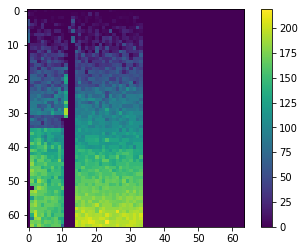

In [78]:
arr = 0
numRows = 64
numCols = 64
vRead = 0.2
vReadGate = 5.0
gains = np.array([4, 3, 2, 1, 0])
maxCurr = np.array([3.2e-3, 650e-6, 110e-6, 14.0e-6, 3.3e-6])
Gmeas = np.zeros((numRows, numCols))
for rr in range(numRows):
        for cc in range(numCols):
            for gg in gains:
                    rdCurr = a0.read_single(vRead, vReadGate, array=arr, row=rr, col=cc, gain=gg)
                    if rdCurr < maxCurr[gg]:
                        break
            Gmeas[rr,cc] = 1e6*rdCurr/vRead
plt.imshow(Gmeas)
plt.colorbar()
save_workspace(vars(), note='DPEReads')

In [76]:
from lib_data import *

In [82]:
numInputs = 2000
arr = 0
Vreads = np.array([0.05, 0.1, 0.15, 0.2, 0.25])
numVReads = 5
gains = np.array([4, 3, 2, 1, 0])
numGains = 5
maxCurr = np.array([3.2e-3, 650e-6, 110e-6, 14.0e-6, 3.3e-6])
inputPattern = np.zeros((numInputs*numVReads,2))
DPECurr = np.zeros((numGains,64))
finalDPECurrs = np.zeros((numInputs*numVReads,64))
for ii in range(numInputs*numVReads):
    Vread = Vreads[ii % numVReads]
    newInputPattern = int(random.getrandbits(16))
    inputPattern[ii] = [newInputPattern, Vread]
    for gg in gains:
        DPECurr[gg] = a0.pic_dpe_batch(arr, [newInputPattern], gain=gg, Vread=Vread, mode=1)
        time.sleep(0.005)
    mask = np.ones((1,64))
    thisDPECurr = np.zeros((1,64))
    for gg in gains:
        thisDPECurr = thisDPECurr + (mask * (DPECurr[gg] * (DPECurr[gg]<=maxCurr[gg])))
        mask = mask * (1 - (DPECurr[gg]<=maxCurr[gg]))
    finalDPECurrs[ii] = thisDPECurr

time.sleep(100)
save_workspace(vars(), note='DPEReadsMany1')
time.sleep(100)

numInputs = 3000
arr = 0
Vreads = np.array([0.05, 0.1, 0.15, 0.2, 0.25])
numVReads = 5
gains = np.array([4, 3, 2, 1, 0])
numGains = 5
maxCurr = np.array([3.2e-3, 650e-6, 110e-6, 14.0e-6, 3.3e-6])
inputPattern = np.zeros((numInputs*numVReads,2))
DPECurr = np.zeros((numGains,64))
finalDPECurrs = np.zeros((numInputs*numVReads,64))
for ii in range(numInputs*numVReads):
    Vread = Vreads[ii % numVReads]
    newInputPattern = int(random.getrandbits(16))
    inputPattern[ii] = [newInputPattern, Vread]
    for gg in gains:
        DPECurr[gg] = a0.pic_dpe_batch(arr, [newInputPattern], gain=gg, Vread=Vread, mode=1)
        time.sleep(0.005)
    mask = np.ones((1,64))
    thisDPECurr = np.zeros((1,64))
    for gg in gains:
        thisDPECurr = thisDPECurr + (mask * (DPECurr[gg] * (DPECurr[gg]<=maxCurr[gg])))
        mask = mask * (1 - (DPECurr[gg]<=maxCurr[gg]))
    finalDPECurrs[ii] = thisDPECurr

save_workspace(vars(), note='DPEReadsMany2')

Saving In(<class 'list'>), Out(<class 'dict'>), PIC_PINS(<class 'dict'>), DAC_CH(<class 'dict'>), DAC_SPAN(<class 'dict'>), REFCLKO(<class 'dict'>), ar(<class 'int'>), r(<class 'int'>), c(<class 'int'>), Vreads(<class 'numpy.ndarray'>), Vgates(<class 'list'>), volts_set(<class 'list'>), Vgate(<class 'int'>), volts(<class 'list'>), vread(<class 'numpy.float64'>), arr(<class 'int'>), rr(<class 'int'>), cc(<class 'int'>), thisGain(<class 'int'>), Vggate(<class 'int'>), numRows(<class 'int'>), numCols(<class 'int'>), vRead(<class 'float'>), vReadGate(<class 'float'>), gains(<class 'numpy.ndarray'>), maxCurr(<class 'numpy.ndarray'>), Gmeas(<class 'numpy.ndarray'>), rdCurr(<class 'float'>), Vread(<class 'numpy.float64'>), data(<class 'numpy.ndarray'>), DPECurr(<class 'numpy.ndarray'>), input(<class 'list'>), gn(<class 'int'>), Vr(<class 'float'>), ts(<class 'float'>), i(<class 'int'>), numInputs(<class 'int'>), inputPattern(<class 'numpy.ndarray'>), ii(<class 'int'>), newInputPattern(<class 

Saving In(<class 'list'>), Out(<class 'dict'>), PIC_PINS(<class 'dict'>), DAC_CH(<class 'dict'>), DAC_SPAN(<class 'dict'>), REFCLKO(<class 'dict'>), ar(<class 'int'>), r(<class 'int'>), c(<class 'int'>), Vreads(<class 'numpy.ndarray'>), Vgates(<class 'list'>), volts_set(<class 'list'>), Vgate(<class 'int'>), volts(<class 'list'>), vread(<class 'numpy.float64'>), arr(<class 'int'>), rr(<class 'int'>), cc(<class 'int'>), thisGain(<class 'int'>), Vggate(<class 'int'>), numRows(<class 'int'>), numCols(<class 'int'>), vRead(<class 'float'>), vReadGate(<class 'float'>), gains(<class 'numpy.ndarray'>), maxCurr(<class 'numpy.ndarray'>), Gmeas(<class 'numpy.ndarray'>), rdCurr(<class 'float'>), Vread(<class 'numpy.float64'>), data(<class 'numpy.ndarray'>), DPECurr(<class 'numpy.ndarray'>), input(<class 'list'>), gn(<class 'int'>), Vr(<class 'float'>), ts(<class 'float'>), i(<class 'int'>), numInputs(<class 'int'>), inputPattern(<class 'numpy.ndarray'>), ii(<class 'int'>), newInputPattern(<class 

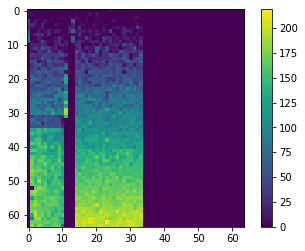

In [83]:
arr = 0
numRows = 64
numCols = 64
vRead = 0.2
vReadGate = 5.0
gains = np.array([4, 3, 2, 1, 0])
maxCurr = np.array([3.2e-3, 650e-6, 110e-6, 14.0e-6, 3.3e-6])
Gmeas = np.zeros((numRows, numCols))
for rr in range(numRows):
        for cc in range(numCols):
            for gg in gains:
                    rdCurr = a0.read_single(vRead, vReadGate, array=arr, row=rr, col=cc, gain=gg)
                    if rdCurr < maxCurr[gg]:
                        break
            Gmeas[rr,cc] = 1e6*rdCurr/vRead
plt.imshow(Gmeas)
plt.colorbar()

time.sleep(30)
save_workspace(vars(), note='DPEArrayRead0_2V')
time.sleep(30)

numInputs = 2000
arr = 0
Vreads = np.array([0.05, 0.1, 0.15, 0.2, 0.25])
numVReads = 5
gains = np.array([4, 3, 2, 1, 0])
numGains = 5
maxCurr = np.array([3.2e-3, 650e-6, 110e-6, 14.0e-6, 3.3e-6])
inputPattern = np.zeros((numInputs*numVReads,2))
DPECurr = np.zeros((numGains,64))
finalDPECurrs = np.zeros((numInputs*numVReads,64))
for ii in range(numInputs*numVReads):
    Vread = Vreads[ii % numVReads]
    newInputPattern = int(random.getrandbits(64))
    inputPattern[ii] = [newInputPattern, Vread]
    for gg in gains:
        DPECurr[gg] = a0.pic_dpe_batch(arr, [newInputPattern], gain=gg, Vread=Vread, mode=1)
        time.sleep(0.005)
    mask = np.ones((1,64))
    thisDPECurr = np.zeros((1,64))
    for gg in gains:
        thisDPECurr = thisDPECurr + (mask * (DPECurr[gg] * (DPECurr[gg]<=maxCurr[gg])))
        mask = mask * (1 - (DPECurr[gg]<=maxCurr[gg]))
    finalDPECurrs[ii] = thisDPECurr

time.sleep(30)
save_workspace(vars(), note='DPEReadsMany3')